In [2]:
from sklearn.model_selection import train_test_split
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context
import numpy as np
import pandas as pd

frame = pd.read_excel("data_gdm_discrete_BMI_merged.xlsx", engine="openpyxl")
frame.oDM = (frame.oDM == 2).astype(int)
for name in frame.columns:
    frame[name] = frame[name].astype('category')

print (frame)
print (frame.oDM.value_counts())

     AgeCat BMICat Race Education GravCat SmokeCat1 SmokeCat2 oDM
0         3      0    1         3       2         1         1   0
1         1      2    2         2       1         1         2   0
2         0      0    2         1       1         2         2   0
3         2      2    3         3       2         2         2   0
4         1      0    3         4       1         2         2   0
...     ...    ...  ...       ...     ...       ...       ...  ..
9215      2      1    1         4       2         1         1   0
9216      1      0    3         3       2         2         2   0
9217      0      0    3         1       2         2         2   0
9218      2      1    1         2       3         1         1   0
9219      3      2    1         5       1         1         1   0

[9220 rows x 8 columns]
0    8832
1     388
Name: oDM, dtype: int64


In [3]:
from sklearn.model_selection import StratifiedKFold
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context
import warnings 

train_data = frame.to_numpy()
names = frame.columns.tolist()
categories = names 
ptypes = [Categorical if n in categories else Gaussian for n in names]
categorical = [n in categories for n in names]

train, test = train_test_split(train_data, stratify = train_data[:, -1], random_state = 0)
print ("%d in train, %d in test" % (len(train), len(test)))

6915 in train, 2305 in test


/home/saurabh/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/saurabh/miniconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/saurabh/miniconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/saurabh/miniconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


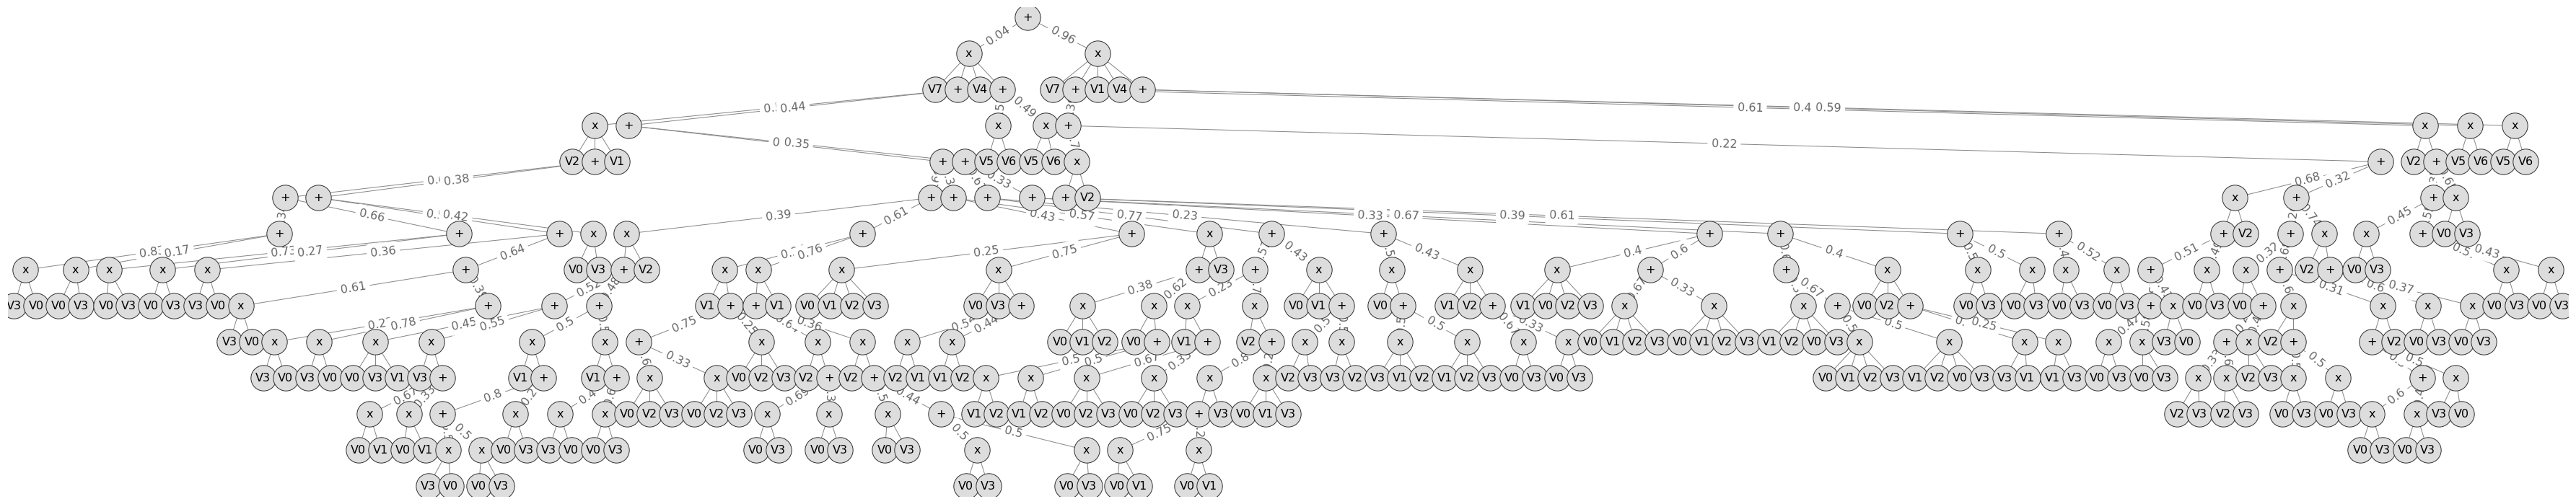

In [4]:
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline


context =  Context(parametric_types=ptypes).add_domains(train)
net = learn_parametric(train, 
                       ds_context = context, 
                       rows = "gmm", 
                       ohe=True, 
                       min_instances_slice = sum(train[:, -1]) / 100)

plt.figure(figsize=(50, 10))
plot_spn(net)

In [8]:
import csi2
from spn.structure.Base import get_nodes_by_type, Product



def format_condition(condition):
    try:
        a, sign, b = condition.split(" ")
    except ValueError as e:
        raise ValueError("Some nodes don't have conditions. reduce min_impurity_decrease")
    
    
    return ("%s %s %s" % (a, sign, b))

print ('#product nodes = ', len(get_nodes_by_type(net, (Product))))

csi2.annotate_spn(net, names, categorical, 
             min_impurity_decrease = 0.1, max_depth = 2)
rules = csi2.context_specific_independences(net, instance_threshold = 0)


rules = csi2.context_specific_independences(net, instance_threshold = 0)
csis = []
ac = []
cc = []
for i, rule in enumerate(rules):
    antecedent, consequent, *scores = rule
    A = csi2.format_antecedent(antecedent, format_condition)
    C = csi2.format_consequent(consequent)
    a_count = csi2.antecedent_count(A)
    c_count = csi2.consequent_count(C)
    ac.append(a_count)
    cc.append(c_count)
    csis.append ("{%s} => {%s} | %.2f, %.2f, %d | %d %d" % (A, C, *scores, a_count, c_count))
print ("%d, %.2f, %.2f" % (len(csis), np.mean(ac), np.mean(cc)))

rules = csi2.context_specific_independences(net, instance_threshold = sum(train[:, -1]) / 20,
                                           precision_threshold = 0.7, recall_threshold = 0.7)
csis = []
ac = []
cc = []
for i, rule in enumerate(rules):
    antecedent, consequent, *scores = rule
    A = csi2.format_antecedent(antecedent, format_condition)
    C = csi2.format_consequent(consequent)
    a_count = csi2.antecedent_count(A)
    c_count = csi2.consequent_count(C)
    ac.append(a_count)
    cc.append(c_count)
    csis.append ("{%s} => {%s} | %.2f, %.2f, %d | %d %d" % (A, C, *scores, a_count, c_count))
print ("%d, %.2f, %.2f" % (len(csis), np.mean(ac), np.mean(cc)))

#product nodes =  104
104, 10.27, 2.33
31, 6.55, 2.19


In [9]:
csis

['{oDM == 1} => {(oDM), (AgeCat,BMICat,Race,Education), (GravCat), (SmokeCat1,SmokeCat2)} | 1.00, 1.00, 291 | 1 4',
 '{oDM != 1} => {(oDM), (AgeCat,Race,Education), (BMICat), (GravCat), (SmokeCat1,SmokeCat2)} | 1.00, 1.00, 6624 | 1 5',
 '{[oDM == 1] & [Race == 1]} => {(Race), (AgeCat,Education), (BMICat)} | 1.00, 1.00, 164 | 2 3',
 '{[oDM == 1] & [SmokeCat1 != 1]} => {(SmokeCat1), (SmokeCat2)} | 1.00, 1.00, 149 | 2 2',
 '{[oDM == 1] & [SmokeCat1 == 1]} => {(SmokeCat1), (SmokeCat2)} | 1.00, 1.00, 142 | 2 2',
 '{[oDM != 1] & [Race == 1]} => {(Race), (AgeCat,Education)} | 1.00, 1.00, 4042 | 2 2',
 '{[oDM != 1] & [SmokeCat1 != 2]} => {(SmokeCat1), (SmokeCat2)} | 1.00, 1.00, 2732 | 2 2',
 '{[oDM != 1] & [SmokeCat1 == 2]} => {(SmokeCat1), (SmokeCat2)} | 1.00, 1.00, 3892 | 2 2',
 '{[oDM != 1] & [Race != 1] & [((Race != 3) & (Race == 2)) | (Race == 3)]} => {(AgeCat,Education), (Race)} | 1.00, 1.00, 2013 | 5 2',
 '{[oDM != 1] & [Race != 1] & [(Race != 3) & (Race != 2)] & [(AgeCat != 0) & (AgeCa

In [68]:
edges = csi2.tree_edges(net, 
               precision_threshold = 0.7,
               recall_threshold = 0.7,
               instance_threshold = sum(train[:, -1]) / 20)
for e in edges:
    a, c, *_ = e 
    if len(a) <=4:
        print (a, c)

[] ['AgeCat', 'BMICat', 'Race', 'Education', 'GravCat', 'SmokeCat1', 'SmokeCat2', 'oDM']
[['oDM == 1']] [['oDM'], ['AgeCat', 'BMICat', 'Race', 'Education'], ['GravCat'], ['SmokeCat1', 'SmokeCat2']]
[['oDM != 1']] [['oDM'], ['AgeCat', 'Race', 'Education'], ['BMICat'], ['GravCat'], ['SmokeCat1', 'SmokeCat2']]
[['oDM == 1']] ['AgeCat', 'BMICat', 'Race', 'Education']
[['oDM == 1']] ['SmokeCat1', 'SmokeCat2']
[['oDM != 1']] ['AgeCat', 'Race', 'Education']
[['oDM != 1']] ['SmokeCat1', 'SmokeCat2']
[['oDM == 1'], ['Race == 1']] [['Race'], ['AgeCat', 'Education'], ['BMICat']]
[['oDM == 1'], ['Race != 1']] ['AgeCat', 'BMICat', 'Race', 'Education']
[['oDM == 1'], ['SmokeCat1 != 1']] [['SmokeCat1'], ['SmokeCat2']]
[['oDM == 1'], ['SmokeCat1 == 1']] [['SmokeCat1'], ['SmokeCat2']]
[['oDM != 1'], ['Race != 1']] ['AgeCat', 'Race', 'Education']
[['oDM != 1'], ['Race == 1']] [['Race'], ['AgeCat', 'Education']]
[['oDM != 1'], ['SmokeCat1 != 2']] [['SmokeCat1'], ['SmokeCat2']]
[['oDM != 1'], ['SmokeCat1 

In [65]:
net.children[0].children[1].children[0].children[1]

SumNode_21

In [9]:
from spn.algorithms.Inference import log_likelihood

print ("%.2f" % np.mean(log_likelihood(net, test)))

-6.92
